In [1]:
import numpy as np
import matplotlib.pyplot as plt

### SIRS Model

In [2]:
states = ["S", "I", "R"]
rules = [("I", "R", 1.0), # spontaneous rule  I -> R with rate 1.0
        ("R", "S", 0.7),  # spontaneous rule R -> S with rate 0.7
        (("I","S"),("I","I"), 0.8)] # contact rule I+S -> I+I with rate 0.4


### Network

In [30]:
graph_as_edgelist = edges_30x30# [(0, 4), (0, 1), (1, 5), (1, 2), (2, 6), (2, 3), (3, 7), (4, 8), (4, 5), (5, 9), (5, 6), (6, 10), (6, 7), (7, 11), (8, 12), (8, 9), (9, 13), (9, 10), (10, 14), (10, 11), (11, 15), (12, 13), (13, 14), (14, 15)]

### Simulation Parameter

In [31]:
horizon = 20.0   # wie lange wird simuliert
initial_distribution = [0.5, 0.5, 0.0] # gleiche Reihenfolge wie states, musss zu rules passen und normalisiert werden
timepoint_num = 101

### Simulation

In [32]:
def get_next_state(current_labels):
    fastes_firing_time = 10000000.0  #dummy
    firing_rule = None
    firing_node = None
    firing_edge = None
    
    # iterate over nodes
    for node in nodes:
        current_state = current_labels[node]
        for rule in rules:
            if 'tuple' in str(type(rule[0])):
                # is contact rule
                continue
            if current_state == rule[0]:
                current_fireing_time = np.random.exponential(1.0/rule[2])
                if current_fireing_time < fastes_firing_time:
                    fastes_firing_time = current_fireing_time
                    firing_rule = rule
                    firing_node = node
                    firing_edge = None
                    
        
    # iterate over edges:
    for edge in graph_as_edgelist:
        node1, node2 = edge
        current_state1 = current_labels[node1]
        current_state2 = current_labels[node2]
        for rule in rules:
            if 'str' in str(type(rule[0])):
                # is spont. rule
                continue
            if (current_state1 == rule[0][0] and current_state2 == rule[0][1]) or (current_state2 == rule[0][0] and current_state1 == rule[0][1]): 
                current_fireing_time = np.random.exponential(1.0/rule[2])
                if current_fireing_time < fastes_firing_time:
                    fastes_firing_time = current_fireing_time
                    firing_rule = rule
                    firing_node = None
                    firing_edge = edge
                

    if firing_rule is None:
        # no rule could fire
        return None, fastes_firing_time # would happen anyway but still
    
    # apply rule
    new_labels = list(current_labels) # copy
    
    if firing_node is not None:
        new_labels[firing_node] = firing_rule[1]
        return new_labels, fastes_firing_time
        
    assert(firing_edge is not None)    
    change_node1 = firing_edge[0]
    change_node2 = firing_edge[1]
    # we have to check which node changes in which direction
    if new_labels[change_node1] == firing_rule[0][0] and new_labels[change_node2] == firing_rule[0][1]:
        new_labels[change_node1] = firing_rule[1][0]
        new_labels[change_node2] = firing_rule[1][1]
    else:
        new_labels[change_node1] = firing_rule[1][1]
        new_labels[change_node2] = firing_rule[1][0]
        

    return new_labels, fastes_firing_time

def count_states(current_labels):
    counter = [0 for _ in states]
    for label in current_labels:
        index = states.index(label)
        counter[index] += 1
    return counter
    

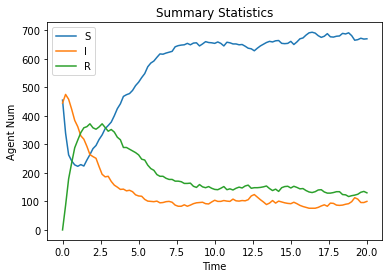

In [35]:
nodes = sorted(list(set([e[0] for e in graph_as_edgelist] + [e[1] for e in graph_as_edgelist])))
assert(nodes == list(range(len(nodes)))) # nodes haben labels 0...<N-1>

# setup
timepoints_samples = np.linspace(0.0, horizon, timepoint_num)
timepoints_samples_static = np.linspace(0.0, horizon, timepoint_num)
initial_labels = list(np.random.choice(states, len(nodes), p=initial_distribution))
current_labels = initial_labels
global_clock = 0.0
labels = list()
timepoints = list()
state_counts = list()


# simulate
while len(timepoints_samples) > 0:
    new_labels, time_passed = get_next_state(current_labels)
    global_clock += time_passed
    #if global_clock+time_passed > timepoints_samples[0]:
    while len(timepoints_samples) > 0 and global_clock > timepoints_samples[0]:
        labels.append(list(current_labels))
        state_counts.append(count_states(current_labels))
        timepoints_samples = timepoints_samples[1:]
    current_labels = new_labels
    
    
# plot
plt.clf()
for i, state in enumerate(states):
    plt.plot(timepoints_samples_static, [c[i] for c in state_counts], label=state)
plt.legend()
plt.title('Summary Statistics')
plt.xlabel('Time')
plt.ylabel('Agent Num')
plt.savefig('current_plot.png', bbox_inches='tight', dpi=300)

### Utils

In [ ]:
import networkx as nx

In [29]:
G = nx.grid_2d_graph(30,30)
G = nx.convert_node_labels_to_integers(G)
edges_30x30 = list(G.edges())